In [1]:
# https://www.kaggle.com/ludobenistant/hr-analytics

In [2]:
import itertools as it
import operator as op
from matplotlib import cm as colmap
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [3]:
df = pd.read_csv("../data/HR.csv")

In [4]:
df.rename(columns = {
    "average_montly_hours": "avg_monthly_hours",
    "Work_accident": "work_accident",
    "sales": "department"
}, inplace = True)
df["salary_low"] = (df["salary"] == "low").astype(int)
df["salary_medium"] = (df["salary"] == "medium").astype(int)
df["salary_high"] = (df["salary"] == "high").astype(int)
df

,satisfaction_level,last_evaluation,number_project,avg_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary,salary_low,salary_medium,salary_high
0,0.38,0.53,2,157,3,0,1,0,sales,low,1,0,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,0,1,0
2,0.11,0.88,7,272,4,0,1,0,sales,medium,0,1,0
3,0.72,0.87,5,223,5,0,1,0,sales,low,1,0,0
4,0.37,0.52,2,159,3,0,1,0,sales,low,1,0,0
5,0.41,0.50,2,153,3,0,1,0,sales,low,1,0,0
6,0.10,0.77,6,247,4,0,1,0,sales,low,1,0,0
7,0.92,0.85,5,259,5,0,1,0,sales,low,1,0,0
8,0.89,1.00,5,224,5,0,1,0,sales,low,1,0,0
9,0.42,0.53,2,142,3,0,1,0,sales,low,1,0,0


In [5]:
len(df[df.left == 1]), len(df)

(3571, 14999)

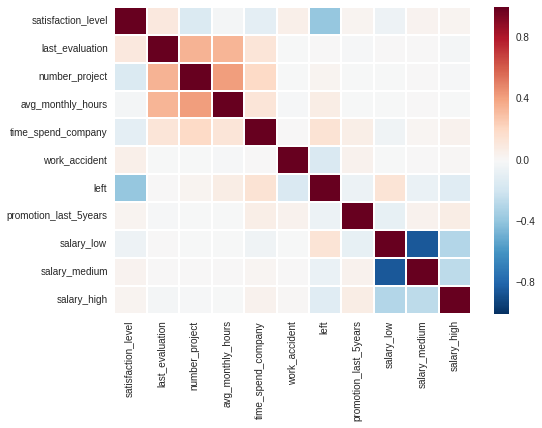

In [6]:
sns.heatmap(df.corr())

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df[["satisfaction_level", "last_evaluation", "number_project", "avg_monthly_hours", "time_spend_company", "work_accident", "promotion_last_5years"]].values,
    df["left"].values, train_size = 0.8, random_state = 1
)

In [8]:
model_poly = make_pipeline(PolynomialFeatures(3), LinearRegression())
model_poly.fit(X_train, y_train)
predictions = model_poly.predict(X_test)
predictions = np.vectorize(lambda x: 0 if x <= 0.5 else 1)(predictions)

In [9]:
print(sum(predictions == y_test), y_test.shape[0])

(2844, 3000)


In [10]:
# ----

In [11]:
import statsmodels.formula.api as smf

In [12]:
formula = "left ~ satisfaction_level + last_evaluation + number_project + avg_monthly_hours + time_spend_company + work_accident==1 + promotion_last_5years==0 + salary_low==1 + salary_high==1 + C(department)"
model = smf.logit(formula, data = df).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.428358
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   left   No. Observations:                14999
Model:                          Logit   Df Residuals:                    14980
Method:                           MLE   Df Model:                           18
Date:                Mon, 01 May 2017   Pseudo R-squ.:                  0.2195
Time:                        11:40:27   Log-Likelihood:                -6424.9
converged:                       True   LL-Null:                       -8232.3
                                        LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -1.6739      0.295     -5.668      0.000      -2.253      -1.095
work_accident == 1[T.True]            -1.5298      0.090    -17.083      0.000      -1.705      -1.354
promotion_last_5years == 0[T.True]     1.4301      0.258      5.552      0.000       0.925       1.935
salary_low == 1[T.True]                0.5308      0.046     11.618      0.000       0.441       0.620
salary_high == 1[T.True]              -1.4132      0.129    -10.924      0.000      -1.667      -1.160
C(department)[T.RandD]                -0.4016      0.136     -2.962      0.003      -0.667      -0.136
C(department)[T.accounting]            0.1807      0.122      1.480      0.139      -0.059       0.420
C(department)[T.hr]                    0.4131      0.121      3.415      0.001       0.176       0.650
C(department)[T.management]           -0.2677      0.152     -1.765      0.078      -0.565       0.030
C(department)[T.marketing]             0.1686      0.122      1.386      0.166      -0.070       0.407
C(department)[T.product_mng]           0.0275      0.120      0.230      0.818      -0.207       0.262
C(department)[T.sales]                 0.1419      0.089      1.601      0.109      -0.032       0.316
C(department)[T.support]               0.2307      0.097      2.391      0.017       0.042       0.420
C(department)[T.technical]             0.2509      0.093      2.685      0.007       0.068       0.434
satisfaction_level                    -4.1357      0.098    -42.177      0.000      -4.328      -3.944
last_evaluation                        0.7309      0.149      4.899      0.000       0.439       1.023
number_project                        -0.3151      0.021    -14.775      0.000      -0.357      -0.273
avg_monthly_hours                      0.0045      0.001      8.643      0.000       0.003       0.005
time_spend_company                     0.2678      0.016     17.192      0.000       0.237       0.298
======================================================================================================
"""

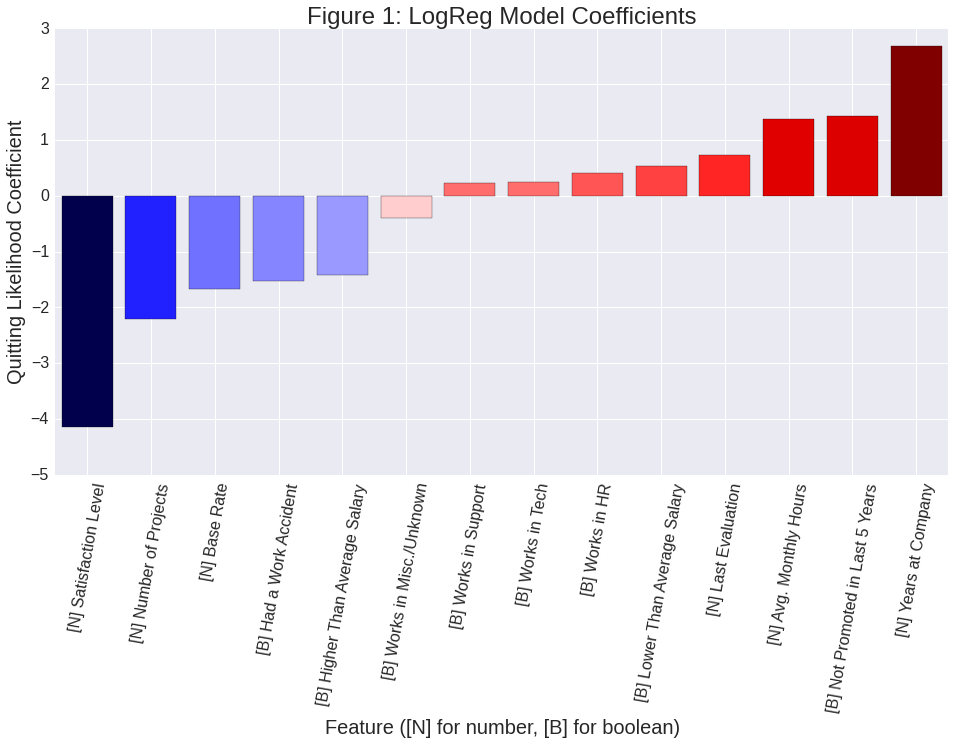

In [13]:
# we only want statistically significant features
significant = model.params[model.pvalues < 0.05]

# numerical variables scale inversely affects coefficient scale, so normalize them
significant.satisfaction_level *= df.satisfaction_level.max()
significant.number_project *= df.number_project.max()
significant.avg_monthly_hours *= df.avg_monthly_hours.max()
significant.time_spend_company *= df.time_spend_company.max()
significant = significant.sort_values()

keys, values = significant.index, significant.values
keys = ["[N] Satisfaction Level", "[N] Number of Projects", "[N] Base Rate", "[B] Had a Work Accident", "[B] Higher Than Average Salary", "[B] Works in Misc./Unknown", "[B] Works in Support", "[B] Works in Tech", "[B] Works in HR", "[B] Lower Than Average Salary", "[N] Last Evaluation", "[N] Avg. Monthly Hours", "[B] Not Promoted in Last 5 Years", "[N] Years at Company"]


fig, ax = plt.subplots(figsize = (16, 8))
positions = [p + 0.1 for p in range(len(values))]
colors = colmap.seismic((values - min(values)) / float(max(values) - min(values)))
ax.bar(positions, values, color = colors)
ax.set_xticks([p + 0.4 for p in positions])
ax.set_xticklabels(keys, rotation = 80)
plt.tick_params(labelsize = 16)
plt.xlabel("Feature ([N] for number, [B] for boolean)", fontsize = 20)
plt.ylabel("Quitting Likelihood Coefficient", fontsize = 20)
plt.title("Figure 1: LogReg Model Coefficients", fontsize = 24)
pass

In [14]:
class CompanyModel(object):
    def __init__(self):
        self.results = pd.DataFrame()

    def train(self, data, formula):
        self.model = smf.logit(formula, data = data).fit()

    def predict(self, keys, vals):
        # model.predict returns probability [0.0 - 1.0] that an employee leaves based on the given conditions;
        # we can extend this probability to be the ratio of employees that leave a company with such conditions
        sample = pd.DataFrame([vals], columns = keys)
        sample["attrition"] = self.model.predict(sample)[0]
        self.results = self.results.append(sample, ignore_index = True)

In [15]:
cm = CompanyModel()
cm.train(df, formula)

Optimization terminated successfully.
         Current function value: 0.428358
         Iterations 7


In [16]:
params = {
    "satisfaction_level":    np.arange(0.0, 1.2, 0.2),
    "last_evaluation":       np.arange(0.0, 1.2, 0.2),
    "number_project":        range(2, 10, 2),
    "avg_monthly_hours":     range(100, 350, 50),
    "time_spend_company":    range(2, 14, 4),
    "work_accident":         [0, 1],
    "promotion_last_5years": [0, 1],
    "salary_low":            [0, 1],
    "salary_high":           [0, 1],
    "department":            ["sales", "technical", "support", "IT", "product_mng", "marketing", "RandD", "accounting", "hr", "management"]
}
keys, vals = zip(*params.items())
for prod in it.product(*vals):
    cm.predict(keys, prod)

In [17]:
cm.results.drop(cm.results.query("salary_low == 1 & salary_high == 1").index, inplace=True)
total = len(cm.results)
for quit_rate in [0.01, 0.05, 0.10]:
    l = len(cm.results[cm.results.attrition <= quit_rate])
    print("attrition <= {0}%: {1} / {2} condition combinations ({3:.2f}%)".format(100 * quit_rate, l, total, 100.0 * l / total))

attrition <= 1.0%: 55441 / 259200 condition combinations (21.39%)
attrition <= 5.0%: 119669 / 259200 condition combinations (46.17%)
attrition <= 10.0%: 151815 / 259200 condition combinations (58.57%)


In [18]:
cm.results.sort_values("attrition", ascending = False)

,satisfaction_level,last_evaluation,work_accident,promotion_last_5years,number_project,department,salary_low,avg_monthly_hours,time_spend_company,salary_high,attrition
48538,0.0,1.0,0,0,2,hr,1,300,10,0,0.991970
38938,0.0,0.8,0,0,2,hr,1,300,10,0,0.990718
48118,0.0,1.0,0,0,2,technical,1,300,10,0,0.990569
48178,0.0,1.0,0,0,2,support,1,300,10,0,0.990379
48532,0.0,1.0,0,0,2,hr,1,250,10,0,0.989984
48478,0.0,1.0,0,0,2,accounting,1,300,10,0,0.989891
48358,0.0,1.0,0,0,2,marketing,1,300,10,0,0.989769
48058,0.0,1.0,0,0,2,sales,1,300,10,0,0.989495
29338,0.0,0.6,0,0,2,hr,1,300,10,0,0.989273
38518,0.0,0.8,0,0,2,technical,1,300,10,0,0.989101


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,satisfaction_level,last_evaluation,work_accident,promotion_last_5years,number_project,department,salary_low,avg_monthly_hours,time_spend_company,salary_high,attrition
29408,0.0,0.6,0,0,4,sales,0,150,6,0,0.794448
29409,0.0,0.6,0,0,4,sales,0,150,6,1,0.484685
29438,0.0,0.6,0,0,4,sales,1,150,6,0,0.867931
87008,0.2,0.6,0,0,4,sales,0,150,6,0,0.628271
87009,0.2,0.6,0,0,4,sales,0,150,6,1,0.291437
87038,0.2,0.6,0,0,4,sales,1,150,6,0,0.741858
144608,0.4,0.6,0,0,4,sales,0,150,6,0,0.424988
144609,0.4,0.6,0,0,4,sales,0,150,6,1,0.152445
144638,0.4,0.6,0,0,4,sales,1,150,6,0,0.556880
202208,0.6,0.6,0,0,4,sales,0,150,6,0,0.244259


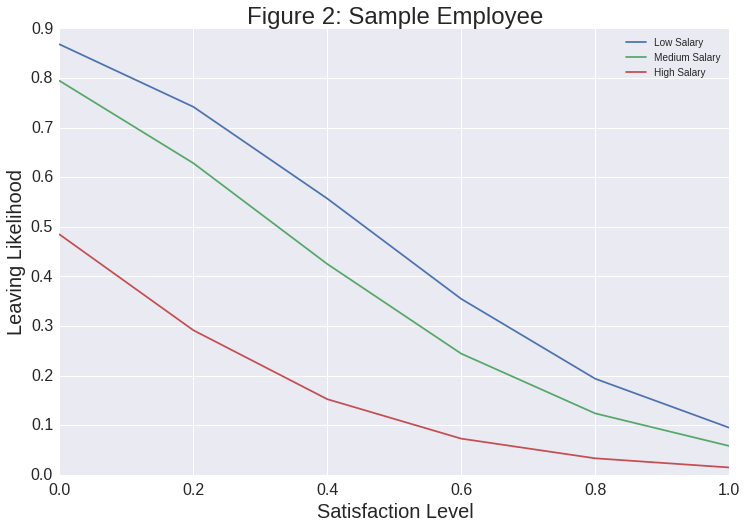

In [19]:
sample = cm.results[cm.results.last_evaluation > 0.4][cm.results.last_evaluation < 0.8][cm.results.department == "sales"][cm.results.avg_monthly_hours == 150][cm.results.work_accident == 0][cm.results.promotion_last_5years == 0][cm.results.time_spend_company == 6][cm.results.number_project == 4]

fig, ax = plt.subplots(figsize = (12, 8))
for l, h, label in [(1, 0, "Low Salary"), (0, 0, "Medium Salary"), (0, 1, "High Salary")]:
    data = sample[sample.salary_low == l][sample.salary_high == h]
    ax.plot(data.satisfaction_level.values, data.attrition.values, label = label)
plt.tick_params(labelsize = 16)
plt.xlabel("Satisfaction Level", fontsize = 20)
plt.ylabel("Leaving Likelihood", fontsize = 20)
plt.title("Figure 2: Sample Employee", fontsize = 24)
plt.legend()
sample

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,satisfaction_level,last_evaluation,work_accident,promotion_last_5years,number_project,department,salary_low,avg_monthly_hours,time_spend_company,salary_high,attrition
202208,0.6,0.6,0,0,4,sales,0,150,6,0,0.244259
202268,0.6,0.6,0,0,4,technical,0,150,6,0,0.264923
202328,0.6,0.6,0,0,4,support,0,150,6,0,0.261023
202388,0.6,0.6,0,0,4,IT,0,150,6,0,0.219018
202448,0.6,0.6,0,0,4,product_mng,0,150,6,0,0.223752
202508,0.6,0.6,0,0,4,marketing,0,150,6,0,0.249221
202568,0.6,0.6,0,0,4,RandD,0,150,6,0,0.158018
202628,0.6,0.6,0,0,4,accounting,0,150,6,0,0.251490
202688,0.6,0.6,0,0,4,hr,0,150,6,0,0.297694
202748,0.6,0.6,0,0,4,management,0,150,6,0,0.176665


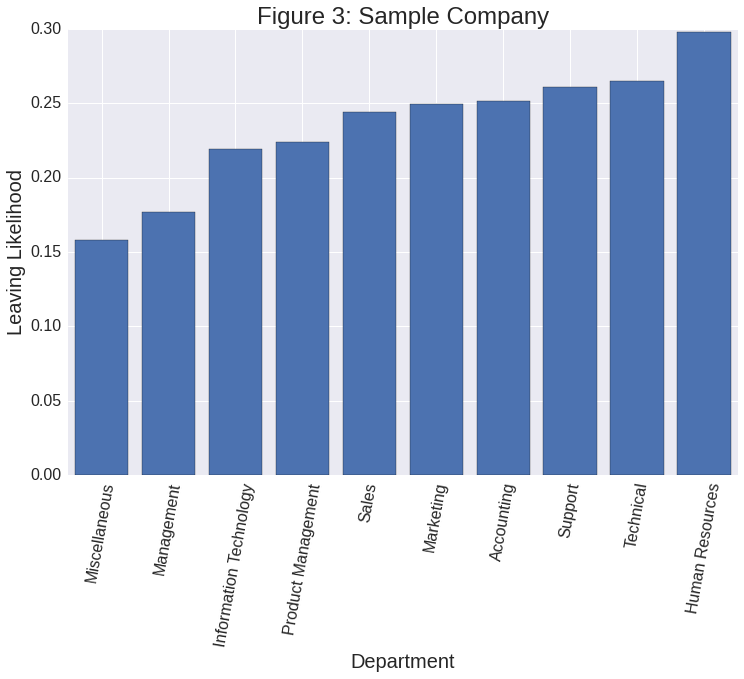

In [25]:
sample = cm.results[cm.results.salary_low == 0][cm.results.salary_high == 0][cm.results.satisfaction_level > 0.4][cm.results.satisfaction_level < 0.8][cm.results.last_evaluation > 0.4][cm.results.last_evaluation < 0.8][cm.results.avg_monthly_hours == 150][cm.results.work_accident == 0][cm.results.time_spend_company == 6][cm.results.promotion_last_5years == 0][cm.results.number_project == 4]

fig, ax = plt.subplots(figsize = (12, 8))
departments = [("RandD", "Miscellaneous"), ("management", "Management"), ("IT", "Information Technology"), ("product_mng", "Product Management"), ("sales", "Sales"), ("marketing", "Marketing"), ("accounting", "Accounting"), ("support", "Support"), ("technical", "Technical"), ("hr", "Human Resources")]
for i, dept in enumerate(departments):
    ax.bar(i + 0.1, sample[sample.department == dept[0]].attrition.values)
ax.set_xticks([i + 0.5 for i in range(len(departments))])
ax.set_xticklabels([dept[1] for dept in departments], rotation = 80)
plt.tick_params(labelsize = 16)
plt.xlabel("Department", fontsize = 20)
plt.ylabel("Leaving Likelihood", fontsize = 20)
plt.title("Figure 3: Sample Company", fontsize = 24)
sample